> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive. 


# Week 2: Named Entity Recognition (NER)

### What we are building
We'll build a model to do NER on an open source MIT Movie Dataset. We will continue to apply our learning philosophy of repetition as we build multiple models of increasing complexity in the following order:

1. Simple model to get a baseline
1. RNN based model
1. Using LSTM. Does it do better? 
1. Using Stacked LSTMs
1. **Extension**: Explore different parameters, features, and metrics. 

###  Evaluation
We will evaluate our models along the following two dimensions: 

1. Accuracy: the ratio of the number of correctly classified instances to the total number of instances. 
1. F1: since this is a multi-class classification problem, we'll add these metrics to each of the runs using the relevant functions from torchmetrics.


### Instructions

1. We've provide scaffolding for all the boiler plate Pytorch code to get to our baseline model. This covers downloading and parsing the dataset, and training code for the baseline model. **Make sure to read all the steps and internalize what is happening**.
1. At this point, our model gets to an accuracy of about 0.78. After this we'll try to improve the model by using RNNs and LSTMs. **Does this improve accuracy?**
1. In the next set of models, we'll stack the LSTM cells and see if they can boost up our model. **How do you think this model will perform?**
1. **Extension**: We have suggested a bunch of extensions to the project so go crazy! Tweak any parts of the pipeline, and see if you can beat all the current modes.

### Code Overview
- Dependencies: Install and import python dependencies
- Project
  - Dataset: Download the MIT dataset, and parse it into a pytorch Dataset
  - Trainer: Trainer function to help with multi-epoch training
  - Model 0: All Zeros
  - Model 1: RNN
  - Model 2: Bidirectional RNN
  - Model 2: LSTM
  - Model 3: Stacked LSTMs
  - More metrics
- Extensions


# Dependencies

✨ Now let's get started! To kick things off, as always, we will install some dependencies.

In [228]:
# Install all the required dependencies for the project
!pip install pytorch-lightning==1.6.5
!pip install spacy==2.2.4
!python -m spacy download en_core_web_md
!pip install scikit-learn==1.0.2
!pip install matplotlib # to render Confusion Matrix
!pip install seaborn # to render Confusion Matrix

     |████████████████████████████████| 293 kB 2.7 MB/s            
You should consider upgrading via the '/Users/vitalii.mishchenko/Documents/experiments/2302-nlp-course/venv/bin/python -m pip install --upgrade pip' command.


Import all the necessary libraries we need throughout the project.

In [ ]:
# Import all the relevant libraries
import spacy
import en_core_web_md
import csv
import itertools

import pytorch_lightning as pl
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
import torchmetrics

Now let's load the Spacy data, which comes with pre-trained embeddings. This process is expensive so only do this once.

In [ ]:
# Really expensive operation to load the entire space word-vector index in memory
# We'll only run it once 
loaded_spacy_model = en_core_web_md.load()

Fix the random seed for numpy and pytorch so the entire class gets consistent results which. We can discuss this with each other.

In [ ]:
# Fix the random seed so that we get consistent results
torch.manual_seed(0)
np.random.seed(0)

# Named Entity Recognition Project 

✨ Let's Begin ✨

### Data Loading and Processing (Common to ALL Solutions)

#### Dataset

We’ll be using the [MIT Movie dataset](https://groups.csail.mit.edu/sls/downloads/movie/). **Extension**: You can find a lot of other entity recognition datasets listed on Github. Play around with them to see how you perform.


In [ ]:
# Download the dataset and move it to a separate folder
!mkdir -p mit_ner
!wget 'https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio' -P './mit_ner'
!wget 'https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio' -P './mit_ner'
!ls mit_ner/

Perfect. Now we see all our files. Let's poke at one of them before we start parsing our dataset.

The file is a 2-column tab separated file. The first column is the label and the second column is the token.

If you need a refresher of IOB label encoding, an O label on a token denotes that the token is not part of a named entity. A "B" label indicates that the token is the start of a named entity, with the description following the "B-" describing the type of entity. An "I" label on a token indicates that the token is part of a named entity but not the first token in the entity, with the description following the "I-" describing the type of entity.

In [ ]:
TRAIN_FILE = "mit_ner/engtrain.bio"
TEST_FILE = "mit_ner/engtest.bio"

# The file is a 2-column tab separated file. 
# The first column is the label and the second column is the token.
# Empty rows refer to a sentence break
with open(TRAIN_FILE, 'r', newline='\n') as file:
  reader = csv.reader(file, delimiter = '\t')
  i = 0
  while(i < 15):
    print(next(reader))
    i += 1

Empty rows refer to a sentence break. Now we should try and parse the dataset file and create a label encoder that converts text labels to integer ids or vice versa

In [ ]:
def parse_dataset(file_path, label_encoder):
  """
  Function to parse the csv into training or test dataset

  Input: Tuple[label,token] or Empty
  Output: List of tuples of label and token. Each list is one sentence.
  """
  data = []
  with open(file_path, 'r') as file:
    reader = csv.reader(file, delimiter = '\t')
    sentence=[]
    for row in reader:
      if len(row) == 0:
        data.append(sentence)
        sentence=[]
      else:
        sentence.append((label_encoder([row[0]])[0], row[1]))
  return data

# Custom encoder that creates the encoding in reverse order so to assign 'O' -> 0
# The default scikit LabelEncoder doesn't allow for that 
# Ref: https://stackoverflow.com/questions/51308994/python-sklearn-determine-the-encoding-order-of-labelencoder
class CustomLabelEncoder():
  def __init__(self):
    self.classes_ = None
    self.transform_map = None
    self.inverse_map = None
  
  def fit(self, y):
    self.transform_map = {}
    self.inverse_map = {}
    self.classes_ = np.unique(y)[::-1] # ["I-PLOT", ... unique labels]
    for i, c in enumerate(self.classes_):
      self.transform_map[c] = i
      self.inverse_map[i] = c # "c" is a label, e.g. "I-PLOT"
    return self

  def transform(self, y):
    return [self.transform_map.get(x) for x in y]

  def inverse_transform(self, y):
    return [self.inverse_map.get(x) for x in y]

# A lable encoder converts the text labels into integer ids
def get_label_encoder():
  """Get all the labels in a dataset and return two maps that convert labels -> id or vice versa.
  """
  # We pass an identity encoder since we still need the raw labels to train the label encoder
  raw_data = parse_dataset(TRAIN_FILE, lambda x: x)
  le = CustomLabelEncoder()
  le.fit([x[0] for sentence in raw_data for x in sentence])
  return le

# Global variables used throughout the notebook
label_encoder = get_label_encoder()

In [ ]:
label_encoder.classes_

Creating the global training, validation, and test datasets from the data files.

In [ ]:
training_data = parse_dataset(TRAIN_FILE, label_encoder.transform)
test_data = parse_dataset(TEST_FILE, label_encoder.transform)

print('# of training examples: {rows}'.format(rows=len(training_data)))
print('# of test examples: {rows}'.format(rows=len(test_data)))

[Dataset and Data loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html): Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

[LightingDataModule](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html#datamodules): A datamodule is a shareable, reusable class that encapsulates all the steps needed to process data. A datamodule encapsulates the five steps involved in data processing in PyTorch:

1. Download / tokenize / process.
2. Clean and (maybe) save to disk.
3. Load inside Dataset.
4. Apply transforms (rotate, tokenize, etc…).
5. Wrap inside a DataLoader.


In [ ]:
class NERDataset(Dataset):
  """Creates an pytorch dataset to consume our pre-loaded csv data

  Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 
  """
  def __init__(self, data, vectorizer):
    self.dataset = data
    # Vectorizer needs to implement a vectorize function that returns vector and tokens
    # 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
    self.vectorizer = vectorizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    words_and_label = self.dataset[idx]
    # Split the input into two different lists per sentence
    labels, words = list(zip(*words_and_label))
    token_vectors, tokens, aligned_labels = self.vectorizer.vectorize(words, labels)
    return {
        "vectors": np.array(token_vectors),
        "tokens": tokens, # for debugging only
        "labels": aligned_labels
      }

We're going to digress for 3 seconds to learn a bit more about the sequence padding function. 

In [ ]:
a = torch.ones(22)
b = torch.ones(15)
c = torch.ones(25)
print("One dimensional Sequence", pad_sequence([a, b, c]).size())
a = torch.ones(22, 300)
b = torch.ones(25, 300)
c = torch.ones(15, 300)
print("Two dimensional Sequence", pad_sequence([a, b, c]).size())

It'll make all the sequences of the max length in the list. Now back to writing the data module wrapper.

In [ ]:
class NERDataModule(pl.LightningDataModule):
  """LightningDataModule: Wrapper class for the dataset to be used in training, test, validation
  """
  def __init__(self, vectorizer, params):
    super().__init__()
    self.params = params
    self.ner_test = NERDataset(test_data, vectorizer)

    # The dataset doesn't have an explicit validation data, so we split the training data into an 80-20 split
    ner_train_val_combined = NERDataset(training_data, vectorizer)

    # Compute the 80-20 split
    train_sample_size = int(len(ner_train_val_combined) * 0.8)
    validation_sample_size = len(ner_train_val_combined)- train_sample_size

    # Create the actual training and validation datasets
    self.ner_train, self.ner_val = random_split(ner_train_val_combined, [train_sample_size, validation_sample_size])
  
  # Function to convert the input raw data from the dataset into model input. 
  # 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
  def collate_fn(self, batch):
    # Separate out the vectors and labels from the batch
    word_vector = [torch.Tensor(item["vectors"]) for item in batch]
    labels = [item["labels"] for item in batch]

    # Now pad each vector sequence to the same size
    padded_word_vector = pad_sequence(word_vector)

    # Max sequence length is the max size of a single sentence in this batch
    max_seq_len = padded_word_vector.shape[0]

    # Pad the label vector as well
    padded_label_vector = []
    for label in labels:
      padded_label = np.concatenate((label, np.array([0] * (max_seq_len - len(label)))))
      padded_label_vector.append(padded_label)
    padded_label_vector = torch.LongTensor(np.array(padded_label_vector))

    # Mask to make sure when computing the loss we're not accounting for the padding
    padded_mask = torch.logical_not(torch.all(torch.isclose(padded_word_vector, torch.tensor(0.0)), dim=-1)).int()

    tokens = [item["tokens"] for item in batch]

    padded_tokens = []
    for token in tokens:
      padded_token = token.copy()
      diff = max_seq_len - len(token)
      while diff > 0:
        padded_token.append('PAD')
        diff -= 1
      padded_tokens.append(padded_token)

    return {"vectors": padded_word_vector, "label_ids": padded_label_vector, "mask": torch.transpose(padded_mask, 0, 1), "tokens": padded_tokens}

  def train_dataloader(self):
    # Training dataloader .. will reset itself each epoch
    return DataLoader(self.ner_train, batch_size=self.params.batch_size, collate_fn=self.collate_fn)

  def val_dataloader(self):
    # Validation dataloader .. will reset itself each epoch
    return DataLoader(self.ner_val, batch_size=self.params.batch_size, collate_fn=self.collate_fn)

  def test_dataloader(self):
    # Test dataloader .. will reset itself each epoch
    return DataLoader(self.ner_test, batch_size=self.params.batch_size, collate_fn=self.collate_fn)

### Classifier and Trainer (Common to all solutions)

Now that we have created the DataLoader and Datasets we'll use in the entire project, it is time to write the training and testing loops. 

[LightingModule](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html): organizes your PyTorch code into 5 sections

1. Computations (init).
2. Train loop (training_step)
3. Validation loop (validation_step)
4. Test loop (test_step)
5. Optimizers (configure_optimizers)

In [ ]:
# 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
class NamedEntityRecognizer(pl.LightningModule):
  def __init__(self, model, params):
      super().__init__()
      self.model = model
      self.params = params
      self.validation_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=params.num_tags, multiclass=True, mdmc_reduce="global")
      self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=params.num_tags, multiclass=True, mdmc_reduce="global")

  def forward(self, x):
      return self.model(x)

  def training_step(self, batch, batch_idx):
    x = batch["vectors"]
    y = batch["label_ids"]
    mask = batch["mask"]
    y_hat = self(x).permute(0, 2, 1)
    loss = F.cross_entropy(y_hat, y, reduction='none')
    active_loss = torch.mean(torch.multiply(loss, mask))
    self.log_dict(
        {'train_loss': active_loss}, 
        batch_size=self.params.batch_size, 
        prog_bar=True
        )
    return active_loss
  
  def validation_step(self, batch, batch_nb):
    x = batch["vectors"]
    y = batch["label_ids"]
    mask = batch["mask"]
    y_hat = self(x)
    val_loss = F.cross_entropy(y_hat.permute(0, 2, 1), y, reduction='none')
    active_loss = torch.mean(torch.multiply(val_loss, mask))
    predictions = torch.argmax(y_hat, dim=2)

    # We apply with the mask here to zero out any predictons that are just made 
    # on the padding from being added to the accuracy calculation
    self.validation_accuracy(predictions*mask, y)
    self.log_dict(
        {
          'val_loss': active_loss,
          'val_accuracy': self.validation_accuracy,
        },
        batch_size=self.params.batch_size, 
        prog_bar=True
      )
    return active_loss

  def test_step(self, batch, batch_nb):
    x = batch["vectors"]
    y = batch["label_ids"]
    mask = batch["mask"]
    y_hat = self(x)
    test_loss = F.cross_entropy(y_hat.permute(0, 2, 1), y, reduction='none')
    active_loss = torch.mean(torch.multiply(test_loss, mask))
    predictions = torch.argmax(y_hat, dim=2)
    # We apply with the mask here to zero out any predictons that are just made 
    # on the padding from being added to the accuracy calculation
    self.test_accuracy(predictions*mask, y)
    self.log_dict(
        {
          'test_loss': active_loss,
          'test_accuracy': self.test_accuracy
        }, 
        batch_size=self.params.batch_size,
        prog_bar=True
      )
    return active_loss
  
  def predict_step(self, batch, batch_idx):
    y_hat = self.model(batch["vectors"])
    predictions = torch.argmax(y_hat, dim=2)
    return {'logits':y_hat, 'predictions': predictions, 'label_ids': batch["label_ids"], 'mask': batch["mask"], 'tokens': batch["tokens"]}

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.params.learning_rate)
    return optimizer

We'll need a Vectorizer to convert words into word vectors. This week we'll just freeze a simple Spacy-based vectorizer and use that for all the models.

In [ ]:
class SpacyVectorizer:
  def vectorize(self, words, labels):
    """
    Given a sentence, tokenize it and returns a pre-trained word vector for each token.
    NOTE: note that the vectorizer needs to be compatible with the tokenizer.
    """
    assert len(words) == len(labels)
    sentence_vector = []
    sentence_labels = []
    sentence_tokens = []
    for i, word in enumerate(words):
      label = labels[i]

      # Tokenize the words using spacy
      spacy_doc = loaded_spacy_model.make_doc(word)
      word_vector = [token.vector for token in spacy_doc]
      word_tokens = [token.text for token in spacy_doc]
      sentence_vector += word_vector
      sentence_tokens += word_tokens

      # Make sure the length of the labels is same as length of vectors
      # In out current dataset we get pre tokenized words so this shouldn't actually happen
      word_labels = [label] * len(word_vector)
      sentence_labels += word_labels
    return sentence_vector, sentence_tokens, sentence_labels

vectorizer = SpacyVectorizer()

Once we have a Lightning and LightingDataModule, a [Trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) automates everything else. It provides functions for training (fit), testing, and inference. We ended up writing a helper function that takes the model, vectorizer, and hyper parameters to be able to easily compare our different models.

In [174]:
def trainer(model, params, skip_training=False):
  # Create a pytorch trainer
  trainer = pl.Trainer(max_epochs=params.max_epochs, check_val_every_n_epoch=1)

  # Initialize our data loader with the passed vectorizer
  data_module = NERDataModule(vectorizer, params)

  # Train and validate the model
  if not skip_training:
    trainer.fit(model,
                data_module.train_dataloader(),
                val_dataloaders=data_module.val_dataloader())

  # Test the model
  trainer.test(model, data_module.test_dataloader())

  # Predict on the same test set to show some output
  output = trainer.predict(model, data_module.test_dataloader())

  # Prepare data for rendering
  sentences_result = []
  for i, token in enumerate(output[0]['tokens']):
    tokens = output[0]['tokens'][i] # all tokens in sentence
    tokens_predicted_labels = output[0]['predictions'][i]
    tokens_label_ids = output[0]['label_ids'][i]

    token_result = []
    for j, token in enumerate(tokens):
      token_prediction_tensor = tokens_predicted_labels[j]
      token_predicted_label = label_encoder.inverse_transform([int(token_prediction_tensor)])[0]

      label_id_tensor = tokens_label_ids[j]
      token_label_id = label_encoder.inverse_transform([int(label_id_tensor)])[0]

      token_result.append({'token': token, 'prediction': token_predicted_label, 'label_id': token_label_id})

    sentences_result.append(token_result)


  for i in range(2):
    print("-----------")
    # print("Label Ids: ", [label_encoder.inverse_transform([int(x)])[0] for x in output[0]['label_ids'][i]])
    # print("Predictions: ", [label_encoder.inverse_transform([int(x)])[0] for x in output[0]['predictions'][i]])
    # print("Tokens: ", [token for token in output[0]['tokens'][i]])

    print("TOKEN PREDICTION LABEL_ID")
    for i, token in enumerate(sentences_result[i]):
      # print(token)
      print(token['token'], token['prediction'], token['label_id'])

    print("Mask: ", output[0]['mask'][i])

  return output

# Models

You may be wondering, "Are we building models yet?" And, the answer is YES! Finally the time has come to build our baseline model, and then we'll work towards improving it. 

### Assignment Part 1: Model 0: Make them all ZERO  -- COMPLETED
##### <font color='red'>Expected accuracy: ~74 - 79%</font>

Build a model that doesn't do any predictions and just returns 0 ('O') for all label ids to be predicted.

This is a good baseline for our model since most of our predictions are 0 anyway so we should get some decent accuracy with just this. Building a model only makes sense if we can at least do better than this :) 

In [ ]:
class HParamsZERO:
  batch_size: int = 32
  learning_rate: float = 0.02
  max_epochs: int = 4
  num_tags: int = len(label_encoder.classes_)

# Model that we are going to train
# torch.nn.Module - Base class for all neural network modules.
class NERModelZero(torch.nn.Module):
  def __init__(self, num_tags):
    super().__init__()
    self.num_tags = num_tags

  # https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.forward
  def forward(self, batch):
    """Batch is of shape (max_seq_len, batch_size, word_vector_dim)
    Returns: Output probabilities of shape (batch_size, max_seq_len, num_tags)
    """
    ### + TO BE IMPLEMENTED ###

    # reshape output to expected format: (batch_size, max_seq_len, num_tags)
    output = batch.permute(1, 0, 2)
    reshaped_output = output[:,:, 0:25]

    # predict that all labels are zero
    predicted_labels = torch.LongTensor(np.array([0] * self.num_tags))
    reshaped_output[:,:, 0:] = predicted_labels

    return reshaped_output

# Train, Validate and Test the model
trainer(
    model=NamedEntityRecognizer(NERModelZero(HParamsZERO.num_tags), 
                                HParamsZERO),
    params=HParamsZERO,
    skip_training=True)  # NOTE: We skip training here since there is no variable to learn in this model

### Assignment Part 2: Model 1: Recurrent Neural Networks  -- COMPLETED
##### <font color='red'>Expected accuracy: ~86 - 92%</font>

Let's build our first [Simple RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) based model. 

Here we've two key pieces:

1. *HParams*: a class that contains all the hyperparameters we reference in the notebook.
1. *NERModelRNN*: Simple RNN model, and it's forward pass implementation. The model should contain one RNN layer, followed by one dropout layer and then one linear layer to compute the output.

It will take several minutes to train the model, so don't be alarmed if you don't get the result right away. When the cell finishes running, under the `DATALOADER:0 TEST RESULTS` section.

In [ ]:
class HParamsRNN:
  batch_size: int = 32
  learning_rate: float = 0.02
  max_epochs: int = 4
  num_tags: int = len(label_encoder.classes_)
  hidden_dim: int = 128 # Added
  dropout: float = 0.2 # Added
  word_vec_dim: int = 300 # Added

class NERModelRNNBasic(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # 🌟🌟🌟 WOOHOO!! We're using RNNs in the model
    ### + TO BE IMPLEMENTED ###

    # We are using off the shelf RNN model provided by torch
    # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
    self.rnn = torch.nn.RNN(
      input_size = HParamsRNN.word_vec_dim,
      hidden_size = HParamsRNN.hidden_dim,
      num_layers = 1
    )

    ### + TO BE IMPLEMENTED ###
    self.dropout = torch.nn.Dropout(HParamsRNN.dropout)
    self.tags = torch.nn.Linear(HParamsRNN.hidden_dim, HParamsRNN.num_tags)
    
  def forward(self, batch):
    """Batch is of shape (max_seq_len, batch_size, word_vector_dim)
    
    Observe that each batch contains sentence encodings of equal length (the length of the longest sentence).
    This is because sentences are variable in length; however, processing sentences
    in batches via (variants of) RNNs needs to be of equal length. We have already added padding, 
    to make each batch the length of the longest sentence in the batch (see NERDataModule.collate_fn()).

    Given the batch, do the following:
    - Implement a hidden state for an RNN.
    - Use the hidden state with the batch for the RNN.
    - Put the RNN through the other layers (dropout, tags).
    - Put the outcome in the appropriate format.

    Returns: Output probabities of shape (batch_size, max_seq_len, num_tags)
    """
    # Propagate input through RNN layer
    ### + TO BE IMPLEMENTED ###

    # Propagate input through RNN layer
    h0 = torch.randn(1, batch.shape[1], HParamsRNN.hidden_dim)
    rnn_output, hn = self.rnn(batch, h0)
    
    # Propagate the rnn output through dropout and linear layers
    final_output = self.tags(self.dropout(rnn_output))
    return torch.transpose(final_output, 0, 1)

# Train, Validate and Test the model

# test_accuracy       0.899971604347229
# test_loss           0.40753209590911865

nerModelRNN1 = NERModelRNNBasic()

trainer(
    model=NamedEntityRecognizer(nerModelRNN1, HParamsRNN),
    params=HParamsRNN)

In [ ]:
# Manually play with the model

sentence = "Will Bruce"

# Prepare values for model: split sentence on tokens, and create embedding for all tokens.
spacy_doc = loaded_spacy_model.make_doc(sentence)
word_vectors = [token.vector for token in spacy_doc]
word_vectors_tensor = [torch.Tensor(word_vectors)]
word_vectors_tensor_padded = pad_sequence(word_vectors_tensor)

# Predict label for tokens

# Contains list of sentences.
# Each sentence is split on token(words).
# Each token has probabilities for all labels.

# Label probabilities for one token with 25 classes will look like this.
# Index position of each number represents the label_id.
#
# tensor([ 0.6291, -2.3706, -3.2754,  1.4866, -0.0955, -7.0612, -6.3131, -7.1562,
#          -0.9303, -5.4489,  3.7505,  1.3431,  2.1410, -6.9045, -8.9719,  2.6642,
#          2.6569, -4.4499, -7.1784, -4.0404, -1.4843, -2.0336,  6.6684,  4.5503,
#          9.2884])
batch_predictions_all_classes = nerModelRNN1(word_vectors_tensor_padded)
sentence_prediction_all_classes = batch_predictions_all_classes[0]


# Find the index position for the number with the highest value, and as result label_id.
sentence_predictions_top_classes = torch.argmax(sentence_prediction_all_classes, dim=1)

# prepare data for printing
sentence_tokens = list([token.text for token in spacy_doc])
predicted_sentence_labels = [label_encoder.inverse_transform([int(x)])[0] for x in sentence_predictions_top_classes]

print("Words", sentence_tokens)
print("Predictions: ", predicted_sentence_labels)

🎉🎉🎉 WE HAVE OUR NER Model that uses RNNs 🎉🎉🎉

Now might be a good time to 1) celebrate!, and 2) re-read the code to internalize it.

### Assignment Part 3: Model 2: Bidirectional Recurrent Neural Networks -- COMPLETED
##### <font color='red'>Expected accuracy: ~86 - 91%</font>

Now that you've got a [simple RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) based model working, we like to add one small addition. This addition, as you might've read from the PyTorch documentation, you can apply to any RNN based model. 

We do this by adding a few parameters which are used to implement bidirectionality for a RNN model.

In [ ]:
class HParamsBiRNN:
  batch_size: int = 32
  learning_rate: float = 0.02
  max_epochs: int = 4
  num_tags: int = len(label_encoder.classes_)
  hidden_dim: int = 128
  dropout: float = 0.2
  word_vec_dim: int = 300
  num_layers: int = 2 # Added
  bidirectional: bool = True # Added

class NERModelRNNAdvanced(torch.nn.Module):
  def __init__(self):
    super().__init__()
    ### + TO BE IMPLEMENTED ###
    self.rnn = torch.nn.RNN(
      bidirectional = HParamsBiRNN.bidirectional, # The main difference from the First Model 1
      num_layers = HParamsBiRNN.num_layers, # The main difference from the First Model 1
      input_size = HParamsBiRNN.word_vec_dim,
      hidden_size = HParamsBiRNN.hidden_dim,
    )

    self.tags = torch.nn.Linear(HParamsBiRNN.hidden_dim*2, HParamsBiRNN.num_tags)
    self.dropout = torch.nn.Dropout(HParamsBiRNN.dropout)
    
  def forward(self, batch):
    """Batch is of shape (max_seq_len, batch_size, word_vector_dim)

    Returns: Output probabities of shape (batch_size, max_seq_len, num_tags)
    """
    # Propagate input through RNN layer
    ### + TO BE IMPLEMENTED ###
    h0 = torch.randn(HParamsBiRNN.num_layers*2, batch.shape[1], HParamsBiRNN.hidden_dim)
    rnn_output, hn = self.rnn(batch, h0)

    # Propagate the rnn output through dropout and linear layers
    dropout_output = self.dropout(rnn_output)
    final_output = self.tags(dropout_output)
    result = torch.transpose(final_output, 0, 1)
    return result

# Train, Validate and Test the model

# test_accuracy       0.8965667486190796
# test_loss           0.4602322280406952
trainer(
    model=NamedEntityRecognizer(NERModelRNNAdvanced(),
                                HParamsBiRNN),
    params=HParamsBiRNN)

Nice! Do we see any performance improvements? What will the change do to the runtime?

We'd like to encourage you to add this option to later models as well and compare.

### Assignment Part 4: Model 3: LSTMs ---- COMPLETED
##### <font color='red'>Expected accuracy: ~89 - 96%</font>

We'll be re-using the simple RNN model from Model-1 but changing the layers from RNN to LSTMs. 

1. Change the RNN layer to [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) Layer
2. Keep the dropout and linear layers in the model
3. Complete the forward pass implementation

Does this model perform better than our baseline?

In [ ]:
class NERModelLSTM(torch.nn.Module):
  def __init__(self, params):
    """
    Three layers: LSTM, dropout and linear chained one after the other.
    """
    super().__init__()
    ### + TO BE IMPLEMENTED ###
    self.params = params
    self.lstm = torch.nn.LSTM(
      input_size = self.params.word_vec_dim,
      hidden_size = self.params.hidden_dim,
      num_layers = self.params.num_layers,
      dropout = self.params.dropout
    )

    self.dropout = torch.nn.Dropout(self.params.dropout)
    self.tags = torch.nn.Linear(self.params.hidden_dim, self.params.num_tags)

  def forward(self, batch):
    """Batch is of shape (max_seq_len, batch_size, word_vector_dim)
    Returns: Output probabilities of shape (batch_size, max_seq_len, num_tags)
    """

    # Propagate the LSTM output through dropout and linear layers
    h0 = torch.randn(self.params.num_layers, batch.shape[1], self.params.hidden_dim)
    c0 = torch.randn(self.params.num_layers, batch.shape[1], self.params.hidden_dim)
    lstm_output, hn = self.lstm(batch, (h0, c0))

    # Propagate the rnn output through dropout and linear layers
    dropout_output = self.dropout(lstm_output)
    final_output = self.tags(dropout_output)
    result = torch.transpose(final_output, 0, 1)
    return result


In [ ]:
class HParamsLSTM:
  batch_size: int = 32
  learning_rate: float = 0.02
  dropout: float = 0.2
  max_epochs: int = 4
  num_tags: int = len(label_encoder.classes_)
  word_vec_dim: int = 300
  hidden_dim: int = 128
  num_layers: int = 1

# Train, Validate and Test the model
# test_accuracy       0.9451950192451477
# test_loss           0.22913846373558044
trainer(
  model=NamedEntityRecognizer(NERModelLSTM(HParamsLSTM),
                              HParamsLSTM),
  params=HParamsLSTM)

Play around with some predictions? On what examples does the LSTM do much better than the RNN?

### Assignment Part 5: Model 4: Stacked LSTMs ---- COMPLETED
##### <font color='red'>Both expected accuracy: ~88 - 96%</font>

So far we have created single layer LSTM and RNNs. Now change the code to create a new stacked LSTM with 2 and 4. How do they perform? 


In [ ]:
# 2 Stacked LSTM
class HParamsLSTMS2:
  batch_size: int = 32
  learning_rate: float = 0.02
  dropout: float = 0.2
  max_epochs: int = 4
  num_tags: int = len(label_encoder.classes_)
  word_vec_dim: int = 300
  hidden_dim: int = 128
  num_layers: int = 2 # Changed to 2

# Train, Validate and Test the model
# test_accuracy       0.9426195621490479
# test_loss           0.2310606688261032
trainer(
    model=NamedEntityRecognizer(NERModelLSTM(HParamsLSTMS2),
                                HParamsLSTMS2),
    params=HParamsLSTMS2)

In [ ]:
# 4 Stacked LSTM
class HParamsLSTMS4:
  batch_size: int = 32
  learning_rate: float = 0.02
  dropout: float = 0.2
  max_epochs: int = 4
  num_tags: int = len(label_encoder.classes_)
  word_vec_dim: int = 300
  hidden_dim: int = 128
  num_layers: int = 4 # Changed to 4

# Train, Validate and Test the model
trainer(
    model=NamedEntityRecognizer(NERModelLSTM(HParamsLSTMS4),
                                HParamsLSTMS4),
    params=HParamsLSTMS4)

### Assignment Part 6: Is Accuracy a good metric? 

We've been using Accuracy as a metric for the last two weeks. Is this a good metric for this problem? Debate and write a short answer below:

---

`Accuracy` is a reliable metric when we have equal number of training examples for each class that model tries to predict.

`Accuracy` won't work well when:
- we have imbalanced classes representation
- let's say we have 70% of training examples for class A
- model predicts them quite well (high True Positive)
- but badly predicts other under-represented classes B, C, D, E...
- Accuracy metric will be high despite that model doesn't predict well the majority of classes (B, C, D, E ....)

Alternative to `accuracy`:
- `Precision` - proportion of classes model predicted as True Positive were truly positive
  - answers to question - can I trust model's positive prediction?
- `Recall` - proportion of classes that model predicted as True Positive to all True positives in data set
  - answer to question - how confident can I be that model predicted all True positive examples?
- `f1` - harmonic mean between `Precision` and `Recall`
  -  harmonic - punishes extreme values

`Precision` and `Recall` are often in tension.

I can increase `Precision` by decreasing `Recall` and vice versa:
- I can increase my confidence in the prediction (precision)
    - if model says it's a spam then for sure it's spam
- but more spam emails will be marked as NOT spam (recall)
    - because model doesn't want to get it wrong

![](./img/recall-precision.png)

`F1` score tries to balance them
![](./img/f1-score.png)

---

### Assignment Part 7: Implement a new LightningModule. --- TO BE COMPLETED
##### <font color='red'>Expected accuracy: ~76 - 80%, expected F1: ~2 - 5%</font>

We're going to compute more metrics on our models. Let's create a new training module which adds **F1 Score** to it.

**NamedEntityRecognizerWithF1**: Implement some functions we've seen multiple times now

1. Initialize the F1 metric correctly with *mdmc_average:global* and *average:macro*.
1. `validation_step`: Write the function that computes validation_loss. It should be really close to what you've seen before.
1. `test_step`: Write the function that computes test_loss. It should be really close to what you've seen before.
1. `predict_step`: Implement a function that does inference here. Will anything need to change here?
1. `configure_optimizers`: Configure adam optimizer to run at the learning rate from the hyper-parameters. Will anything need to change here?


Good explanation: [of micro vs macro averages for multiclass classification](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/24051#24051)

Another reading for metrics on multi-class classification is [here](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd)


In [ ]:
from torchmetrics import F1Score

class HParamsF1:
  batch_size: int = 32
  learning_rate: float = 0.02
  max_epochs: int = 4
  max_seq_len: int = 20
  hidden_dim: int = 128
  word_vec_dim: int = 300
  num_layers: int = 1
  dropout: float = 0.2
  num_tags: int = len(label_encoder.classes_)

class NamedEntityRecognizerWithF1(pl.LightningModule):
  def __init__(self, model, params):
      super().__init__()
      self.model = model
      self.params = params
      self.validation_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=params.num_tags, mdmc_reduce="global")
      self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=params.num_tags, mdmc_reduce="global")
      ### ADD YOUR NEW METRICS ###
      self.validation_f1 = torchmetrics.F1Score(task="multiclass", num_classes=params.num_tags)

      # https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html
      self.test_f1 = torchmetrics.F1Score(task="multiclass", num_classes=params.num_tags, mdmc_average="global", average="macro")

  def forward(self, x):
      return self.model(x)

  def training_step(self, batch, batch_idx):
    x = batch["vectors"]
    y = batch["label_ids"]
    mask = batch["mask"]
    y_hat = self(x).permute(0, 2, 1)
    loss = F.cross_entropy(y_hat, y, reduction='none')
    active_loss = torch.mean(torch.multiply(loss, mask))
    self.log_dict(
      {'train_loss': active_loss},
      batch_size=self.params.batch_size,
      prog_bar=True
    )
    return active_loss

  def validation_step(self, batch, batch_nb):
    x = batch["vectors"]
    y = batch["label_ids"]
    mask = batch["mask"]
    y_hat = self(x)
    val_loss = F.cross_entropy(y_hat.permute(0, 2, 1), y, reduction='none')
    active_loss = torch.mean(torch.multiply(val_loss, mask))
    predictions = torch.argmax(y_hat, dim=2)

    # We apply with the mask here to zero out any predictions that are just made
    # on the padding from being added to the accuracy calculation
    self.validation_accuracy(predictions*mask, y)

    # f1
    self.validation_f1(predictions*mask, y)

    self.log_dict(
      {
        'val_loss': active_loss,
        'val_accuracy': self.validation_accuracy,
        'val_f1': self.validation_f1,
      },
      batch_size=self.params.batch_size,
      prog_bar=True
    )
    return active_loss

  def test_step(self, batch, batch_nb):
    x = batch["vectors"]
    y = batch["label_ids"]
    mask = batch["mask"]
    y_hat = self(x)
    test_loss = F.cross_entropy(y_hat.permute(0, 2, 1), y, reduction='none')
    active_loss = torch.mean(torch.multiply(test_loss, mask))
    predictions = torch.argmax(y_hat, dim=2)
    # We apply with the mask here to zero out any predictions that are just made
    # on the padding from being added to the accuracy calculation
    self.test_accuracy(predictions*mask, y)

    # f1
    self.test_f1(predictions*mask, y)

    self.log_dict(
      {
        'test_loss': active_loss,
        'test_accuracy': self.test_accuracy,
        'test_f1': self.test_f1
      },
      batch_size=self.params.batch_size,
      prog_bar=True
    )
    return active_loss

  def predict_step(self, batch, batch_idx):
    y_hat = self.model(batch["vectors"])
    predictions = torch.argmax(y_hat, dim=2)
    return {'logits':y_hat, 'predictions': predictions, 'label_ids': batch["label_ids"], 'mask': batch["mask"], 'tokens': batch["tokens"]}

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.params.learning_rate)
    return optimizer

# Train, Validate and Test the model
# test_accuracy      0.7869786620140076
# test_f1            0.03523169830441475
# test_loss          1.768639087677002
trainer(
    model=NamedEntityRecognizerWithF1(NERModelZero(HParamsF1.num_tags), HParamsF1),
    params=HParamsF1,
    skip_training=True)  # NOTE: We skip training here since there is no variable to learn in this model

#### Let's re-run our RNN and LSTM models once with the new metrics
##### <font color='red'>Expected accuracy: ~82 - 90%, expected F1: ~32 - 36%</font>
##### <font color='red'>Expected accuracy: ~88 - 96%, expected F1: ~65 - 70%</font>

In [ ]:
# test_accuracy      0.8855664730072021
# test_f1            0.3759670555591583
# test_loss          0.49065735936164856
trainer(
    model=NamedEntityRecognizerWithF1(NERModelRNNAdvanced(), HParamsRNN),
    params=HParamsRNN)

In [ ]:
# HParamsLSTM (1 layer) - BEST
# test_accuracy      0.9442128539085388
# test_f1            0.6869888305664062
# test_loss          0.23160669207572937

# HParamsLSTMS2 (2 layers)
# test_accuracy      0.9437108635902405
# test_f1            0.6675513982772827
# test_loss          0.2306649386882782

# HParamsLSTMS4 (4 layers)
# test_accuracy      0.9434270858764648
# test_f1            0.6824137568473816
# test_loss          0.2404809147119522
trainer(
    model=NamedEntityRecognizerWithF1(NERModelLSTM(HParamsLSTMS4), HParamsLSTMS4),
    params=HParamsLSTMS4)

🎉 CONGRATS on finishing the assignment!!! Now is a good time to pause and reflect how much progress we've made in understanding NER, using RNNs, and LSTMs. But hey, don't stop here! There is a lot to do or play with in the next section.

---

# Extensions

Now that you've worked through the project. There is a lot more for us to try.

- See if you can use a LSTM to improve the model you shipped in Week 1.
- Which model performed the best? Why do you think that was?
  - LSTM model with 1 layer based on f1 score
- Why and how many stacks can we keep adding here ?
- Experiment with the hyper parameters to see how much can you improve each of the models
- Use a conditional random field (CRF) along with LSTM. [Tutorial](https://towardsdatascience.com/conditional-random-field-tutorial-in-pytorch-ca0d04499463)
- Visualize a [confusion matrix](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html) of N*N of actual class vs predicted class (N = number of classes)
- Try out other [NER datasets](https://github.com/juand-r/entity-recognition-datasets) on our models.

## Confusion Matrix

In [244]:
# Render confusion Matrix for Best Model ()

# train model  for Confusion Matrix
modelForConfusionMatrix = NERModelLSTM(HParamsLSTMS4)
outputForConfusionMatrix = trainer(
  model=NamedEntityRecognizerWithF1(modelForConfusionMatrix, HParamsLSTMS4),
  params=HParamsLSTMS4)

# build matrix

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | model               | NERModelLSTM       | 619 K 
1 | validation_accuracy | MulticlassAccuracy | 0     
2 | test_accuracy       | MulticlassAccuracy | 0     
3 | validation_f1       | MulticlassF1Score  | 0     
4 | test_f1             | MulticlassF1Score  | 0     
-----------------------------------------------------------
619 K     Trainable params
0         Non-trainable params
619 K     Total params
2.479     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/vitalii.mishchenko/Documents/experiments/2302-nlp-course/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Users/vitalii.mishchenko/Documents/experiments/2302-nlp-course/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/vitalii.mishchenko/Documents/experiments/2302-nlp-course/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9225833415985107
         test_f1             0.49835404753685
        test_loss           0.33070191740989685
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/vitalii.mishchenko/Documents/experiments/2302-nlp-course/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting: 245it [00:00, ?it/s]

-----------
TOKEN PREDICTION LABEL_ID
are O O
there O O
any O O
good O O
romantic B-GENRE B-GENRE
comedies I-GENRE I-GENRE
out O O
right O B-YEAR
now O I-YEAR
PAD B-PLOT O
PAD I-PLOT O
PAD I-PLOT O
PAD I-PLOT O
Mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], dtype=torch.int32)
-----------
TOKEN PREDICTION LABEL_ID
show O O
me O O
a O O
movie O O
about O O
cars B-TITLE B-PLOT
that O I-PLOT
talk O I-PLOT
PAD I-TITLE O
PAD I-TITLE O
PAD I-TITLE O
PAD I-TITLE O
PAD I-TITLE O
Mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], dtype=torch.int32)


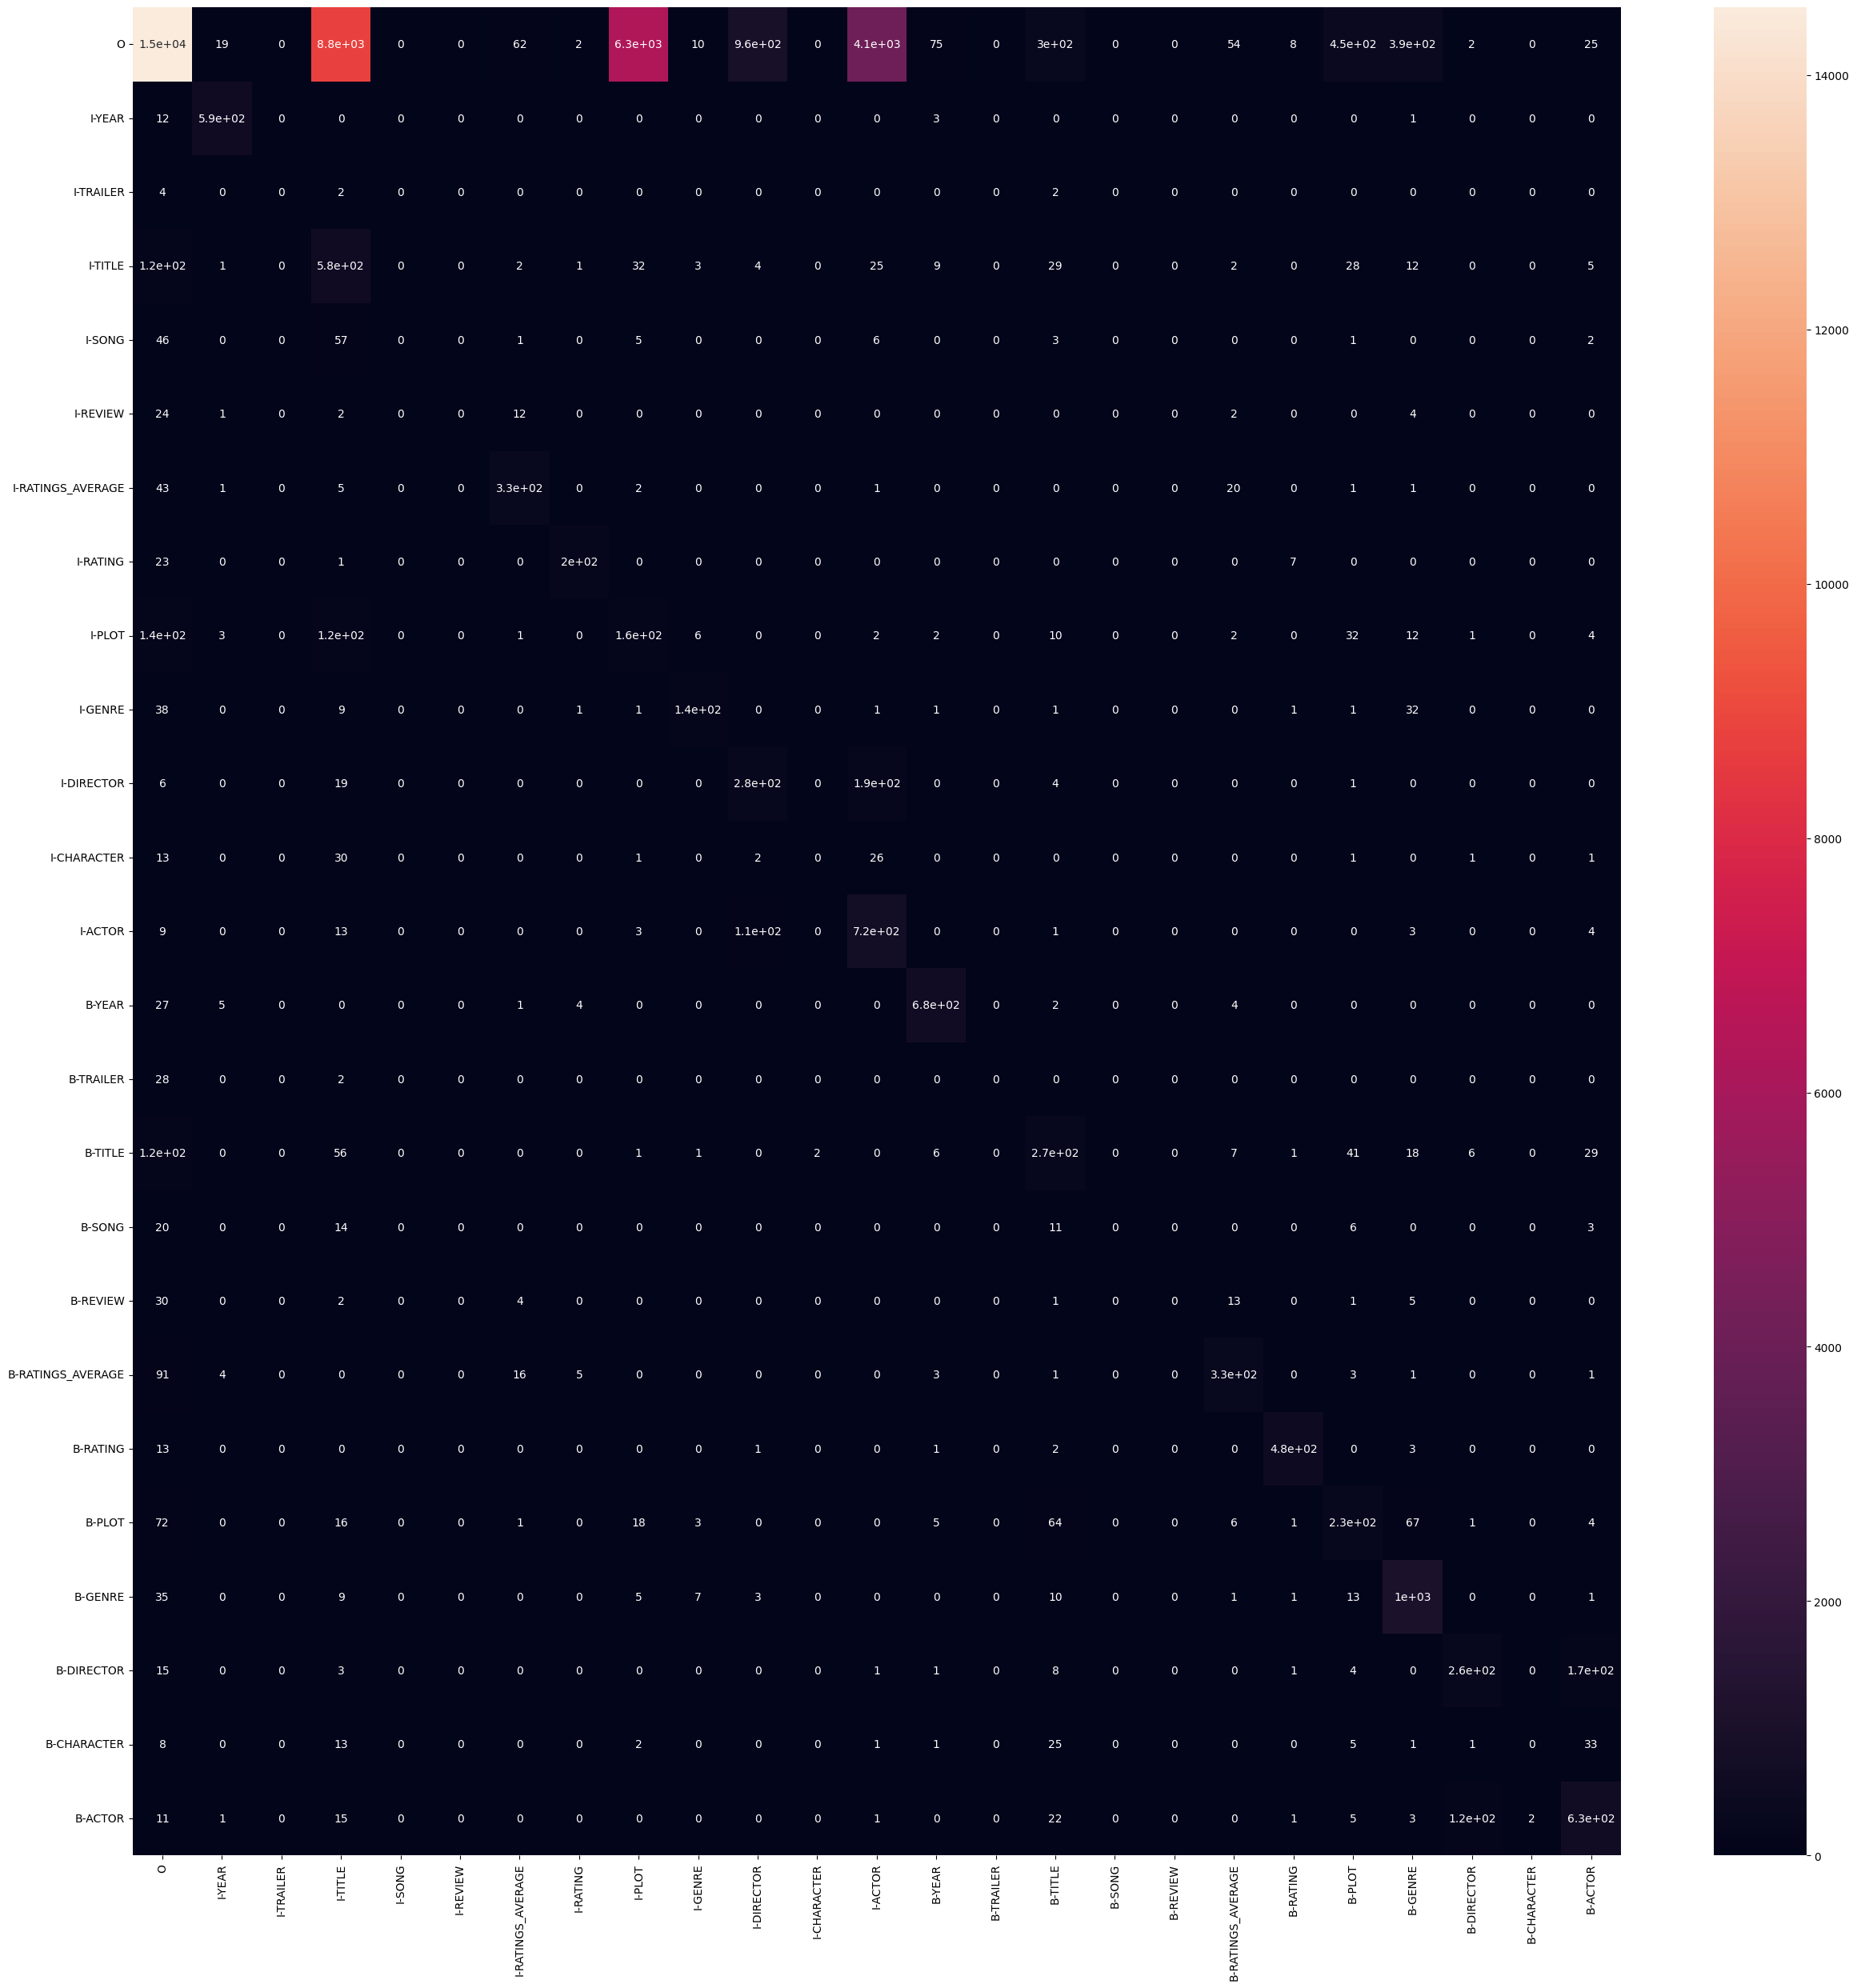

In [247]:
from torchmetrics.functional.classification import multiclass_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

true_labels = []
predicted_labels = []
for o in outputForConfusionMatrix:
  for b, batch in enumerate(o['label_ids']):
    for t, token_label_id in enumerate(o['label_ids'][b]):
      true_labels.append(token_label_id)
      predicted_label_id = o['predictions'][b][t]
      predicted_labels.append(predicted_label_id)
true_labels = torch.Tensor(true_labels)
predicted_labels = torch.Tensor(predicted_labels)

cm = multiclass_confusion_matrix(predicted_labels, true_labels, num_classes=num_classes)

# render
fig, ax = plt.subplots(figsize=(30, 30))
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()
